# Cognee + LangGraph Integration Guide

This notebook demonstrates how to integrate **Cognee** (a semantic memory for AI agents) with **LangGraph** (an agent orchestration framework) to create AI agents with persistent, cross-session memory capabilities powered by knowledge graphs + embeddings.

## What is Cognee?

**Cognee** is an open-source semantic memory layer that transforms unstructured, structured, semi-strictured data into queryable knowledge graphs backed by embeddings. Cognee:

- **Automatically extracts** entities, relationships, and semantic meaning from text
- **Creates knowledge graphs** with embeddings 
- **Enables natural language queries** to retrieve relevant information
- **Maintains context** across different sessions and interactions
- **Supports multi-modal data** including text, documents, and structured data

## What is LangGraph? 

**LangGraph** is an orchestration framework for complex agentic systems  It provides:

- **State Management**: Persistent conversation state across interactions
- **Tool Integration**: Easy integration with external APIs and services
- **Conditional Routing**: Dynamic flow control based on agent decisions
- **Pre-built Patterns**: Ready-to-use agent architectures like ReAct

## Why Combine Them?

The Cognee-LangGraph integration provides AI agents with persistent, semantic memory that survives between sessions. Agents can store information in Cognee's knowledge graph and retrieve it using natural language queries, enabling more accurate retrieval, continuity across conversations without manual state management.

Let's explore how this works in practice!


## Environment Setup

Both LangGraph and Cognee require an OpenAI API key for LLM operations (You can swap providers later; the graph logic stays the same.) Let's configure the environment:


In [ ]:
import os

# Set your OpenAI API key here or use environment variables
# Get your API key from: https://platform.openai.com/api-keys
os.environ["OPENAI_API_KEY"] = "your-openai-api-key-here"

## LangGraph Fundamentals

Before diving into the Cognee integration, let's understand LangGraph's core building blocks:

### State Management
**State** defines what information flows through your graph. LangGraph uses TypedDict to define structured state that persists across nodes.

### Nodes 
**Nodes** are functions that process state and return updates. Each node receives the current state and can modify it.

### Edges
**Edges** define how information flows between nodes. They can be:
- **Simple**: Direct connections (A → B)
- **Conditional**: Dynamic routing based on state content

As an example, we’ll define a tiny state (a list of messages), initialize a chat model, and create a single chatbot node that appends the LLM’s reply to the message list.

In [2]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from langchain.chat_models import init_chat_model


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = init_chat_model("openai:gpt-4.1")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

### Connecting the Graph

Now we need to connect our nodes with edges to create a complete execution flow:

- **START**: Entry point for the graph
- **END**: Exit point for the graph  
- **Edges**: Define the path from START → chatbot → END

This creates a linear flow where every message goes through our chatbot node:

In [3]:
from langgraph.graph import START, END

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

### How does the LangGraph look like right now?

Let's visualize our simple chatbot graph to understand the flow:

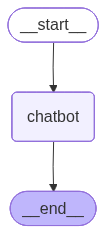

In [4]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [5]:
graph.get_graph().print_ascii()

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
 +---------+   
 | chatbot |   
 +---------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


### Testing the Basic Chatbot

Let's create a helper function to interact with our graph and test it with a simple question:

In [6]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


stream_graph_updates("what is the capital of Argentina?")

Assistant: The capital of Argentina is **Buenos Aires**.


## Adding Tools to LangGraph

Our current chatbot can only chat - it has no access to external information. Let's add **tools** to give it real capabilities!

### WikiData Tool Integration

We'll use LangChain's WikiData tool to give our agent access to knowledge from Wikidata.


Let's test the tool directly first:

In [7]:
from langchain_community.tools.wikidata.tool import WikidataAPIWrapper, WikidataQueryRun

wikidata_tool = WikidataQueryRun(api_wrapper=WikidataAPIWrapper())

print(wikidata_tool.run("Alan Turing"))

Result Q7251:
Label: Alan Turing
Description: English computer scientist (1912–1954)
Aliases: Alan M. Turing, Alan Mathieson Turing, Turing, Alan Mathison Turing
instance of: human
country of citizenship: United Kingdom
occupation: computer scientist, mathematician, university teacher, cryptographer, logician, statistician, marathon runner, artificial intelligence researcher
sex or gender: male
date of birth: 1912-06-23
date of death: 1954-06-07
sport: athletics
place of birth: Maida Vale, Warrington Lodge
educated at: King's College, Princeton University, Sherborne School, Hazlehurst Community Primary School
employer: Victoria University of Manchester, Government Communications Headquarters, University of Cambridge, National Physical Laboratory
place of death: Wilmslow
field of work: cryptanalysis, computer science, mathematics, logic, cryptography
cause of death: cyanide poisoning
notable work: On Computable Numbers, with an Application to the Entscheidungsproblem, Computing Machiner

### Creating a Tool Node

To integrate tools into our LangGraph, we need a **tool node** that can:

1. **Receive tool calls** from the LLM
2. **Execute the requested tools** with provided arguments  
3. **Return results** back to the conversation flow

This node acts as a bridge between the LLM's tool calling capabilities and actual tool execution:

In [8]:
from langchain_core.messages import ToolMessage
import json


class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        print("calling basic tool node...")
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages found in inputs")
        outputs = []
        for tool_call in message.tool_calls:
            print(f"tool {tool_call} being processed...")
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

### Updating the Chatbot for Tools

Now we need to make several updates to enable tool usage:

1. **Create tool node instance** with our WikiData tool
2. **Bind tools to the LLM** so it knows what tools are available
3. **Update the chatbot node** to use the tool-enabled LLM

The `bind_tools()` method tells the LLM about available tools and their schemas, enabling it to generate proper tool calls:

In [9]:
tools = [wikidata_tool]
tool_node = BasicToolNode(tools)

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

### Plugging into LangGraph

Now we need **conditional routing** to decide when to use tools. The LLM might:
- **Answer directly** (no tools needed) → go to END
- **Make tool calls** (tools needed) → go to tools node

We need a **routing function** that examines the LLM's response and decides the next step:



In [10]:
def route_tools(state: State):
    if messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError("No messages found in inputs")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"

    return END

### Building the Tool-Enabled Graph

Now let's assemble all the pieces into a complete graph:

1. **Add chatbot node** (with tool-enabled LLM)
2. **Add tools node** (for executing tools)  
3. **Add conditional edge** (chatbot → tools OR END)
4. **Add return edge** (tools → chatbot for follow-up)

This creates a **ReAct pattern**: Reasoning → Acting → Observing → Reasoning...

In [11]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile()

### Enchanced Graph

Our graph now has more complexity! Notice:
- **New tools node** for executing external tools
- **Conditional edge** that can route to either tools or END  
- **Cycle back** from tools to chatbot for processing results

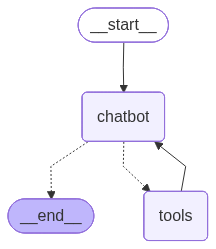

In [12]:
Image(graph.get_graph().draw_mermaid_png())

In [13]:
graph.get_graph().print_ascii()

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +---------+         
          | chatbot |         
          +---------+         
          .         *         
        ..           **       
       .               *      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


### Testing the Tool-Enabled Agent

Let's test our enhanced graph with a query that should trigger the WikiData tool. 


In [14]:
stream_graph_updates("Alan Turing")

Assistant: 
calling basic tool node...
tool {'name': 'Wikidata', 'args': {'query': 'Alan Turing'}, 'id': 'call_sJrhKAorzlldPjQRF3lPhCEy', 'type': 'tool_call'} being processed...


Assistant: "Result Q7251:\nLabel: Alan Turing\nDescription: English computer scientist (1912\u20131954)\nAliases: Alan M. Turing, Alan Mathieson Turing, Turing, Alan Mathison Turing\ninstance of: human\ncountry of citizenship: United Kingdom\noccupation: computer scientist, mathematician, university teacher, cryptographer, logician, statistician, marathon runner, artificial intelligence researcher\nsex or gender: male\ndate of birth: 1912-06-23\ndate of death: 1954-06-07\nsport: athletics\nplace of birth: Maida Vale, Warrington Lodge\neducated at: King's College, Princeton University, Sherborne School, Hazlehurst Community Primary School\nemployer: Victoria University of Manchester, Government Communications Headquarters, University of Cambridge, National Physical Laboratory\nplace of death: Wilmslow\nfield of work: cryptanalysis, computer science, mathematics, logic, cryptography\ncause of death: cyanide poisoning\nnotable work: On Computable Numbers, with an Application to the Entsch

## Introducing Cognee to LangGraph: Semantic Memory for Agents

Now let's add **persistent semantic memory** to our agents using Cognee! 

### What Cognee Adds to LangGraph:

- **Semantic Memory**: Store and retrieve information using natural language from cognee's knowledge graph backed by embeddings
- **Knowledge Graphs**: Automatic entity and relationship extraction  
- **Cross-Session Persistence**: Memory survives between different agent instances
- **Intelligent Search**: Find relevant information by meaning using cognee's advanced retrieval methods
- **Session Isolation**: Keep different users' data separate and secure

### Cognee Tools Integration

The integration provides two main tools:
- **`add_tool`**: Store information in Cognee's knowledge graph
- **`search_tool`**: Query stored information using natural language

Let's configure Cognee and see it in action:


In [15]:
# Before we start using cognee, we need to define a few env variables for cognee
os.environ["LLM_API_KEY"] = os.environ["OPENAI_API_KEY"]
os.environ["LLM_MODEL"] = "gpt-4o-mini"

In [16]:
from cognee_integration_langgraph import add_tool, search_tool
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    "openai:gpt-4o-mini",
    tools=[
        add_tool,
        search_tool,
    ],
)
agent.step_timeout = None


2025-10-15T14:59:10.028538 [info     ] Logging initialized            [cognee.shared.logging_utils] cognee_version=0.2.4 database_path=/Users/handekafkas/Documents/local-code/cognee-integration-langgraph/.venv/lib/python3.12/site-packages/cognee/.cognee_system/databases graph_database_name= os_info='Darwin 23.6.0 (Darwin Kernel Version 23.6.0: Fri Jul  5 17:55:37 PDT 2024; root:xnu-10063.141.1~2/RELEASE_ARM64_T6030)' python_version=3.12.8 relational_config=cognee_db structlog_version=25.4.0 vector_config=lancedb

2025-10-15T14:59:10.029105 [info     ] Database storage: /Users/handekafkas/Documents/local-code/cognee-integration-langgraph/.venv/lib/python3.12/site-packages/cognee/.cognee_system/databases [cognee.shared.logging_utils]


You can see in the diagram that it's essentially the same graph

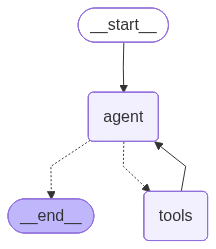

In [17]:
Image(agent.get_graph().draw_mermaid_png())

Also, let's run pruning - so that we know we're starting from a clean slate state

In [18]:
import cognee

await cognee.prune.prune_data()
await cognee.prune.prune_system(metadata=True)


2025-10-15T14:59:11.604093 [info     ] Deleted Kuzu database files at /Users/handekafkas/Documents/local-code/cognee-integration-langgraph/.venv/lib/python3.12/site-packages/cognee/.cognee_system/databases/cognee_graph_kuzu [cognee.shared.logging_utils]

2025-10-15T14:59:14.343259 [info     ] Database deleted successfully. [cognee.shared.logging_utils]


### Background Data Ingestion

Now let's add some additional data directly to Cognee (bypassing the agent) to demonstrate how the agent can access pre-existing knowledge:

This simulates a scenario where:
- **Historical data** exists in the knowledge base
- **Agent interactions** add new information  
- **Both sources** are searchable together

The agent will be able to search across all this information seamlessly:


Let's give our agent a set of inputs that it can memorize in Cognee

In [19]:
from langchain_core.messages import HumanMessage

response = agent.invoke(
    {
        "messages": [
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Meditech Solutions". Company is in the healthcare industry. Start date is Jan 2023 and end date is Dec 2025. Contract value is £1.2M.
            """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "QuantumSoft". Company is in the technology industry. Start date is Aug 2024 and end date is Aug 2028. Contract value is £5.5M.
            """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Orion Retail Group". Company is in the retail industry. Start date is Mar 2024 and end date is Mar 2026. Contract value is £850K.
            """
            ),
        ],
    }
)


print("=== FIRST RESPONSE ===")
print(response["messages"][-1].content)


Adding data to cognee: Signed a contract with QuantumSoft in the technology industry. Start date: Aug 2024, End date: Aug 2028, Contract value: £5.5M.

Adding data to cognee: Signed a contract with Meditech Solutions in the healthcare industry. Start date: Jan 2023, End date: Dec 2025, Contract value: £1.2M.

Adding data to cognee: Signed a contract with Orion Retail Group in the retail industry. Start date: Mar 2024, End date: Mar 2026, Contract value: £850K.

Async operation completed successfully

Async operation completed successfully

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


User ee24a2ef-9672-42c0-873c-bf4790f6ddc9 has registered.



EmbeddingRateLimiter initialized: enabled=False, requests_limit=60, interval_seconds=60

2025-10-15T14:59:20.480682 [info     ] Pipeline run started: `3e354714-beb0-5a10-a495-74f547f7dd57` [run_tasks_with_telemetry()]

2025-10-15T14:59:20.742194 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-10-15T14:59:20.951449 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]

2025-10-15T14:59:21.173570 [info     ] Registered loader: pypdf_loader [cognee.infrastructure.loaders.LoaderEngine]

2025-10-15T14:59:21.174026 [info     ] Registered loader: text_loader [cognee.infrastructure.loaders.LoaderEngine]

2025-10-15T14:59:21.174397 [info     ] Registered loader: image_loader [cognee.infrastructure.loaders.LoaderEngine]

2025-10-15T14:59:21.174684 [info     ] Registered loader: audio_loader [cognee.infrastructure.loaders.LoaderEngine]

2025-10-15T14:59:21.175010 [info     ] Registered loader: unstructured_loader [cognee.infrastructure.loaders.L

=== FIRST RESPONSE ===
The contracts have been successfully logged:

1. **Meditech Solutions** (Healthcare)
   - Start Date: Jan 2023
   - End Date: Dec 2025
   - Contract Value: £1.2M

2. **QuantumSoft** (Technology)
   - Start Date: Aug 2024
   - End Date: Aug 2028
   - Contract Value: £5.5M

3. **Orion Retail Group** (Retail)
   - Start Date: Mar 2024
   - End Date: Mar 2026
   - Contract Value: £850K

If you need any further assistance, feel free to ask!


Cool!

Let's also add some data into our knowledge graph (bypassing the agent).

In [20]:
agent.step_timeout = None

data_dir = os.path.join(os.getcwd(), "data")
for filename in os.listdir(data_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(data_dir, filename)
        with open(file_path, "r") as f:
            content = f.read()
            await cognee.add(content)
await cognee.cognify()


2025-10-15T15:00:16.720709 [info     ] Pipeline run started: `3e354714-beb0-5a10-a495-74f547f7dd57` [run_tasks_with_telemetry()]

2025-10-15T15:00:16.917481 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-10-15T15:00:17.126529 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]

2025-10-15T15:00:17.349706 [info     ] Coroutine task completed: `ingest_data` [run_tasks_base]

2025-10-15T15:00:17.563851 [info     ] Coroutine task completed: `resolve_data_directories` [run_tasks_base]

2025-10-15T15:00:17.826865 [info     ] Pipeline run completed: `3e354714-beb0-5a10-a495-74f547f7dd57` [run_tasks_with_telemetry()]

2025-10-15T15:00:18.040371 [info     ] Ontology file 'None' not found. No owl ontology will be attached to the graph. [OntologyAdapter]

2025-10-15T15:00:18.062544 [info     ] Pipeline run started: `d774b867-31c2-56ec-8032-7309fdf50b8f` [run_tasks_with_telemetry()]

2025-10-15T15:00:18.263996 [info     ] Coroutine task starte

{UUID('05ace0d7-e747-53bb-811d-126825f04047'): PipelineRunCompleted(status='PipelineRunCompleted', pipeline_run_id=UUID('fb885fb5-de54-5e41-afb5-2ff5573eb27d'), dataset_id=UUID('05ace0d7-e747-53bb-811d-126825f04047'), dataset_name='main_dataset', payload=None, data_ingestion_info=[{'run_info': PipelineRunAlreadyCompleted(status='PipelineRunAlreadyCompleted', pipeline_run_id=UUID('fb885fb5-de54-5e41-afb5-2ff5573eb27d'), dataset_id=UUID('05ace0d7-e747-53bb-811d-126825f04047'), dataset_name='main_dataset', payload=None, data_ingestion_info=None), 'data_id': UUID('30dd3235-3e36-5f69-9277-5ce0d2915c0f')}, {'run_info': PipelineRunAlreadyCompleted(status='PipelineRunAlreadyCompleted', pipeline_run_id=UUID('fb885fb5-de54-5e41-afb5-2ff5573eb27d'), dataset_id=UUID('05ace0d7-e747-53bb-811d-126825f04047'), dataset_name='main_dataset', payload=None, data_ingestion_info=None), 'data_id': UUID('5c7bfec2-ae06-5e42-ad2e-2aa2f68efa1b')}, {'run_info': PipelineRunAlreadyCompleted(status='PipelineRunAlread

### Let's visualize the graph from cognee

In [21]:
import webbrowser


async def visualize_graph(file_name, open_browser=True):
    destination_file_path = os.path.join(os.getcwd(), file_name)

    await cognee.visualize_graph(destination_file_path)

    if open_browser:
        url = "file://" + os.path.abspath(destination_file_path)
        webbrowser.open(url)


await visualize_graph(file_name="first_graph_visualization.html")


2025-10-15T15:01:10.361769 [info     ] Graph visualization saved as /Users/handekafkas/Documents/local-code/cognee-integration-langgraph/examples/first_graph_visualization.html [cognee.shared.logging_utils]

2025-10-15T15:01:10.362417 [info     ] The HTML file has been stored at path: /Users/handekafkas/Documents/local-code/cognee-integration-langgraph/examples/first_graph_visualization.html [cognee.shared.logging_utils]


From the specified path above, open the `first_graph_visualization.html` in your browser (if not automatically opened). You can see clients.txt subgraph and input from LangGraph agent interactions distinctly. Below you can also find a screenshot of it.

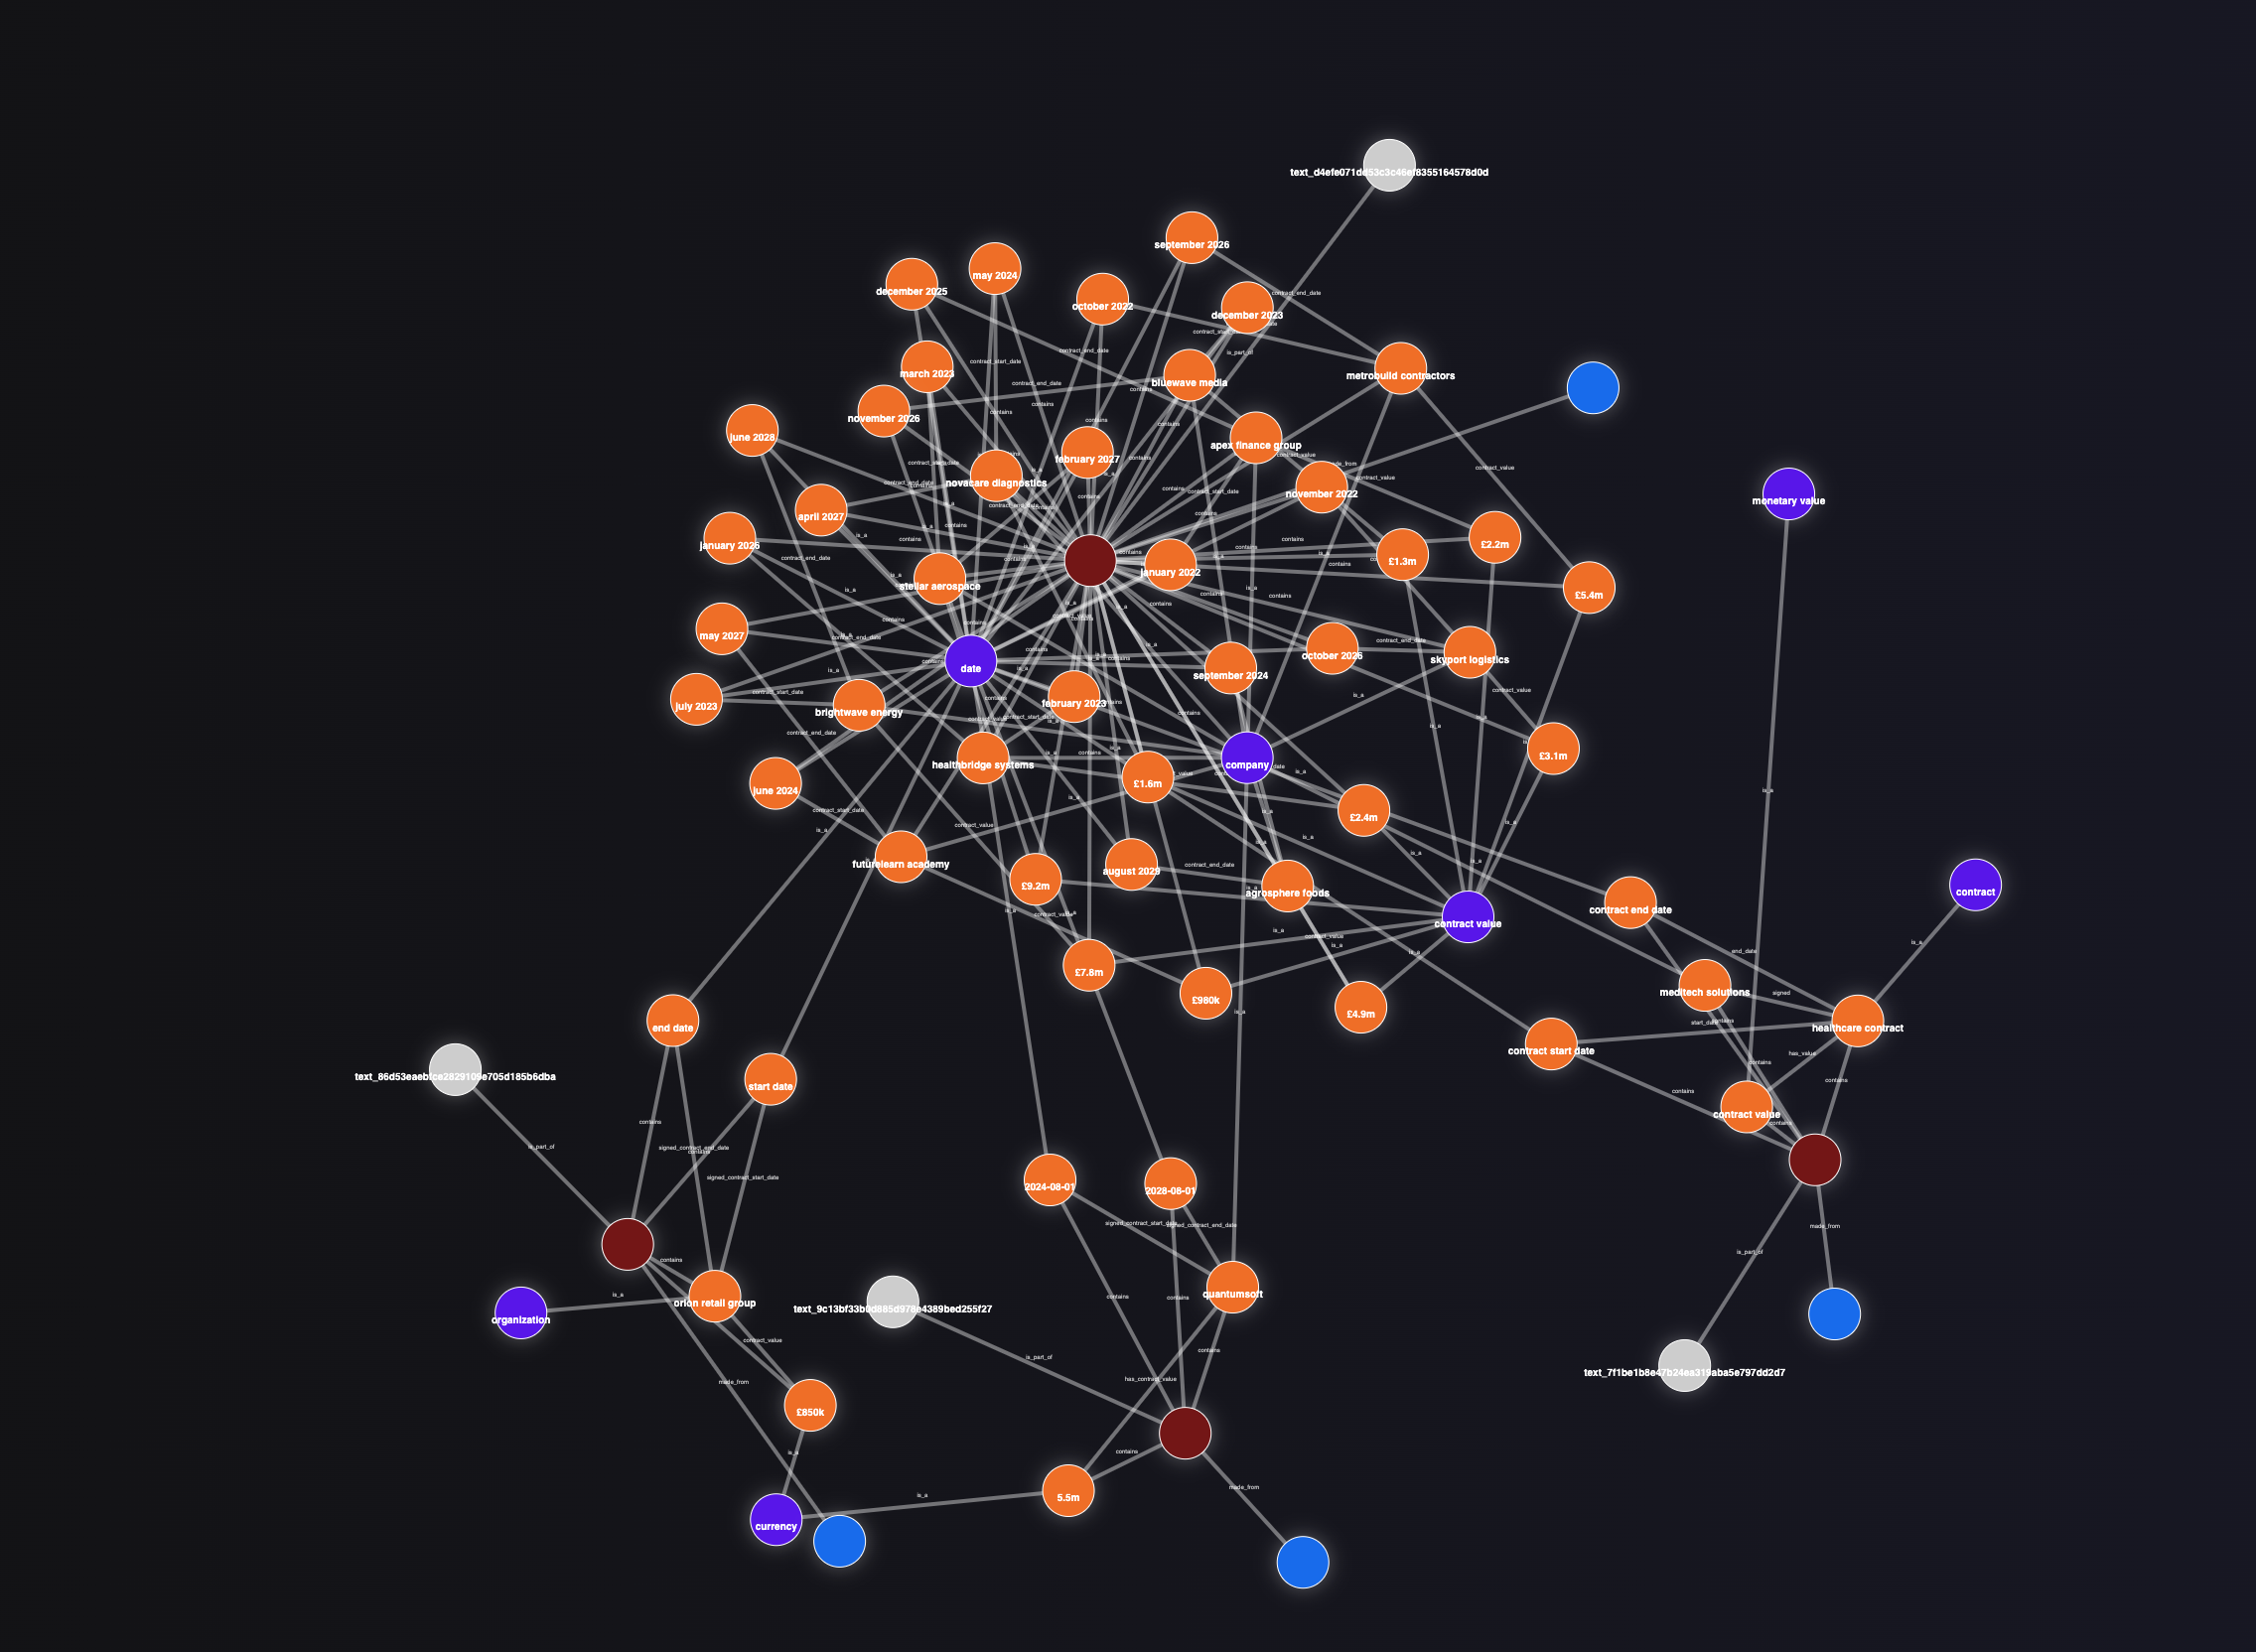

In [22]:
from IPython.display import Image, display

display(Image(filename="./images/first_graph_screenshot.png"))

## Cross-Session Memory Persistence

Now let's demonstrate one of Cognee's key features: **persistent memory across agent instances**.

We'll create a completely fresh agent instance that:
- Has **no conversation history** from the previous agent
- Has **no internal state** carried over  
- **CAN access** all information stored in Cognee's knowledge graph

This shows how Cognee provides **true persistent memory** that survives agent restarts:


In [23]:
# Create a fresh agent instance to avoid memory interference
fresh_agent = create_react_agent(
    "openai:gpt-4o-mini",
    tools=[
        add_tool,
        search_tool,
    ],
)
# Note: LangGraph by default can retry running tools if it considers it's running too long, so we're explicitly setting timeout to None so it doesn't retry
agent.step_timeout = None

response = fresh_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content="I need to research our contract portfolio. Can you search for any contracts we have with companies in the healthcare industry? Please use the search functionality to find this information."
            ),
        ],
    }
)
print("\n=== SECOND RESPONSE ===")
print(response["messages"][-1].content)


Searching cognee for: contracts with companies in the healthcare industry

Async operation completed successfully

2025-10-15T15:02:07.538377 [info     ] Graph projection completed: 48 nodes, 92 edges in 0.01s [CogneeGraph]

2025-10-15T15:02:08.097190 [info     ] Vector collection retrieval completed: Retrieved distances from 6 collections in 0.09s [cognee.shared.logging_utils]

Async operation completed successfully

Search results: ['The following contracts were signed with companies in the healthcare industry:\n1. HealthBridge Systems:\n   - Contract Start Date: February 2023\n   - End Date: January 2026\n   - Contract Value: £2.4M\n\n2. NovaCare Diagnostics:\n   - Contract Start Date: May 2024\n   - End Date: April 2027\n   - Contract Value: £1.6M\n\n3. Meditech Solutions:\n   - Contract Start Date: January 2023\n   - End Date: December 2025\n   - Contract Value: £1.2M.']



=== SECOND RESPONSE ===
Here are the contracts we have with companies in the healthcare industry:

1. **HealthBridge Systems**
   - Contract Start Date: February 2023
   - End Date: January 2026
   - Contract Value: £2.4M

2. **NovaCare Diagnostics**
   - Contract Start Date: May 2024
   - End Date: April 2027
   - Contract Value: £1.6M

3. **Meditech Solutions**
   - Contract Start Date: January 2023
   - End Date: December 2025
   - Contract Value: £1.2M

If you need more details or further assistance, let me know!


## Sessions with Cognee

Let's say we want to add our own, custom state into LangGraph.

There are two possible ways to consider:
1. Define a wrapper around `create_react_agent`
2. Define tools such that they know the state

To minimize confusion, we define tools such that they know the state.

```python
def get_sessionized_cognee_tools(user_id: str) -> list:
    """
    Returns a list of cognee tools sessionized for a specific user.
    
    Args:
        user_id (str): The user session ID to bind to all tools
        
    Returns:
        list: List of sessionized cognee tools
    """
    session_decorator = sessionised_tool(user_id)
    
    sessionized_add_tool = tool(session_decorator(add_tool.func))
    sessionized_search_tool = tool(session_decorator(search_tool.func))
    
    return [
        sessionized_add_tool,
        sessionized_search_tool,
    ]
```

In [24]:
# Let's start with a clean slate

await cognee.prune.prune_data()
await cognee.prune.prune_system(metadata=True)


2025-10-15T15:02:36.652492 [info     ] Deleted Kuzu database files at /Users/handekafkas/Documents/local-code/cognee-integration-langgraph/.venv/lib/python3.12/site-packages/cognee/.cognee_system/databases/cognee_graph_kuzu [cognee.shared.logging_utils]

2025-10-15T15:02:38.705647 [info     ] Database deleted successfully. [cognee.shared.logging_utils]


In [25]:
from cognee_integration_langgraph import get_sessionized_cognee_tools

add_tool, search_tool = get_sessionized_cognee_tools()

super_fresh_agent = create_react_agent(
    "openai:gpt-4o-mini",
    tools=[
        add_tool,
        search_tool,
    ],
)

super_fresh_agent.step_timeout = None

response = super_fresh_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Guardian Insurance Ltd". Company is in the insurance industry. Start date is Feb 2023 and end date is Feb 2026. Contract value is £1.8M.
            """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Pioneer Assurance Group". Company is in the insurance industry. Start date is Oct 2024 and end date is Oct 2029. Contract value is £4.2M.
            """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Finovate Systems". Company is in the fintech industry. Start date is May 2024 and end date is May 2027. Contract value is £2.3M.
            """
            ),
        ],
    }
)

print("=== FIRST RESPONSE ===")
print(response["messages"][-1].content)


Initialized session with session_id = cognee-test-user-5b40dfb7-2462-46ff-8831-b6551266d89a

Using tool add_tool with user_id: cognee-test-user-5b40dfb7-2462-46ff-8831-b6551266d89a

Using tool add_tool with user_id: cognee-test-user-5b40dfb7-2462-46ff-8831-b6551266d89a

Adding data to cognee: Signed contract with Pioneer Assurance Group, insurance industry, start date Oct 2024, end date Oct 2029, contract value £4.2M.

Using tool add_tool with user_id: cognee-test-user-5b40dfb7-2462-46ff-8831-b6551266d89a

Adding data to cognee: Signed contract with Guardian Insurance Ltd, insurance industry, start date Feb 2023, end date Feb 2026, contract value £1.8M.

Adding data to cognee: Signed contract with Finovate Systems, fintech industry, start date May 2024, end date May 2027, contract value £2.3M.

Async operation completed successfully

Async operation completed successfully

2025-10-15T15:02:45.797303 [info     ] Pipeline run started: `4c7fb208-e513-5fc5-acda-33e393e48e97` [run_tasks_wi

User 66bdb751-59e1-40a1-a1b0-703076d02fb0 has registered.



2025-10-15T15:02:46.016332 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-10-15T15:02:46.243118 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]

2025-10-15T15:02:46.467520 [info     ] Coroutine task completed: `ingest_data` [run_tasks_base]

2025-10-15T15:02:46.668415 [info     ] Coroutine task completed: `resolve_data_directories` [run_tasks_base]

2025-10-15T15:02:46.872222 [info     ] Pipeline run completed: `4c7fb208-e513-5fc5-acda-33e393e48e97` [run_tasks_with_telemetry()]

2025-10-15T15:02:47.109047 [info     ] Pipeline run started: `4c7fb208-e513-5fc5-acda-33e393e48e97` [run_tasks_with_telemetry()]

2025-10-15T15:02:47.326493 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-10-15T15:02:47.524293 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]

2025-10-15T15:02:47.750759 [info     ] Coroutine task completed: `ingest_data` [run_tasks_base]

2025-10-15T15:02:48.019977 

=== FIRST RESPONSE ===
The contracts have been successfully recorded:

1. **Guardian Insurance Ltd** - Insurance industry, Start Date: Feb 2023, End Date: Feb 2026, Contract Value: £1.8M.
2. **Pioneer Assurance Group** - Insurance industry, Start Date: Oct 2024, End Date: Oct 2029, Contract Value: £4.2M.
3. **Finovate Systems** - Fintech industry, Start Date: May 2024, End Date: May 2027, Contract Value: £2.3M.

If you need any further information or assistance, feel free to ask!


Let's add one more input, but not as part of the session - and see how it renders!

In [26]:
await cognee.add(
    'We have signed a contract with the following company: "Pied Piper Technologies". Company is in the fintech industry. Start date is Jan 2025 and end date is Jan 2028. Contract value is £3.1M.'
)
await cognee.cognify()
await visualize_graph(file_name="second_graph_visualization_sessionised.html")


2025-10-15T15:03:42.672763 [info     ] Pipeline run started: `4c7fb208-e513-5fc5-acda-33e393e48e97` [run_tasks_with_telemetry()]

2025-10-15T15:03:42.873711 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-10-15T15:03:43.090805 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]

2025-10-15T15:03:43.312146 [info     ] Coroutine task completed: `ingest_data` [run_tasks_base]

2025-10-15T15:03:43.750302 [info     ] Coroutine task completed: `resolve_data_directories` [run_tasks_base]

2025-10-15T15:03:43.953853 [info     ] Pipeline run completed: `4c7fb208-e513-5fc5-acda-33e393e48e97` [run_tasks_with_telemetry()]

2025-10-15T15:03:44.166037 [info     ] Ontology file 'None' not found. No owl ontology will be attached to the graph. [OntologyAdapter]

2025-10-15T15:03:44.187662 [info     ] Pipeline run started: `053be8fa-eda2-50a3-9e25-3093e69932be` [run_tasks_with_telemetry()]

2025-10-15T15:03:44.380159 [info     ] Coroutine task starte

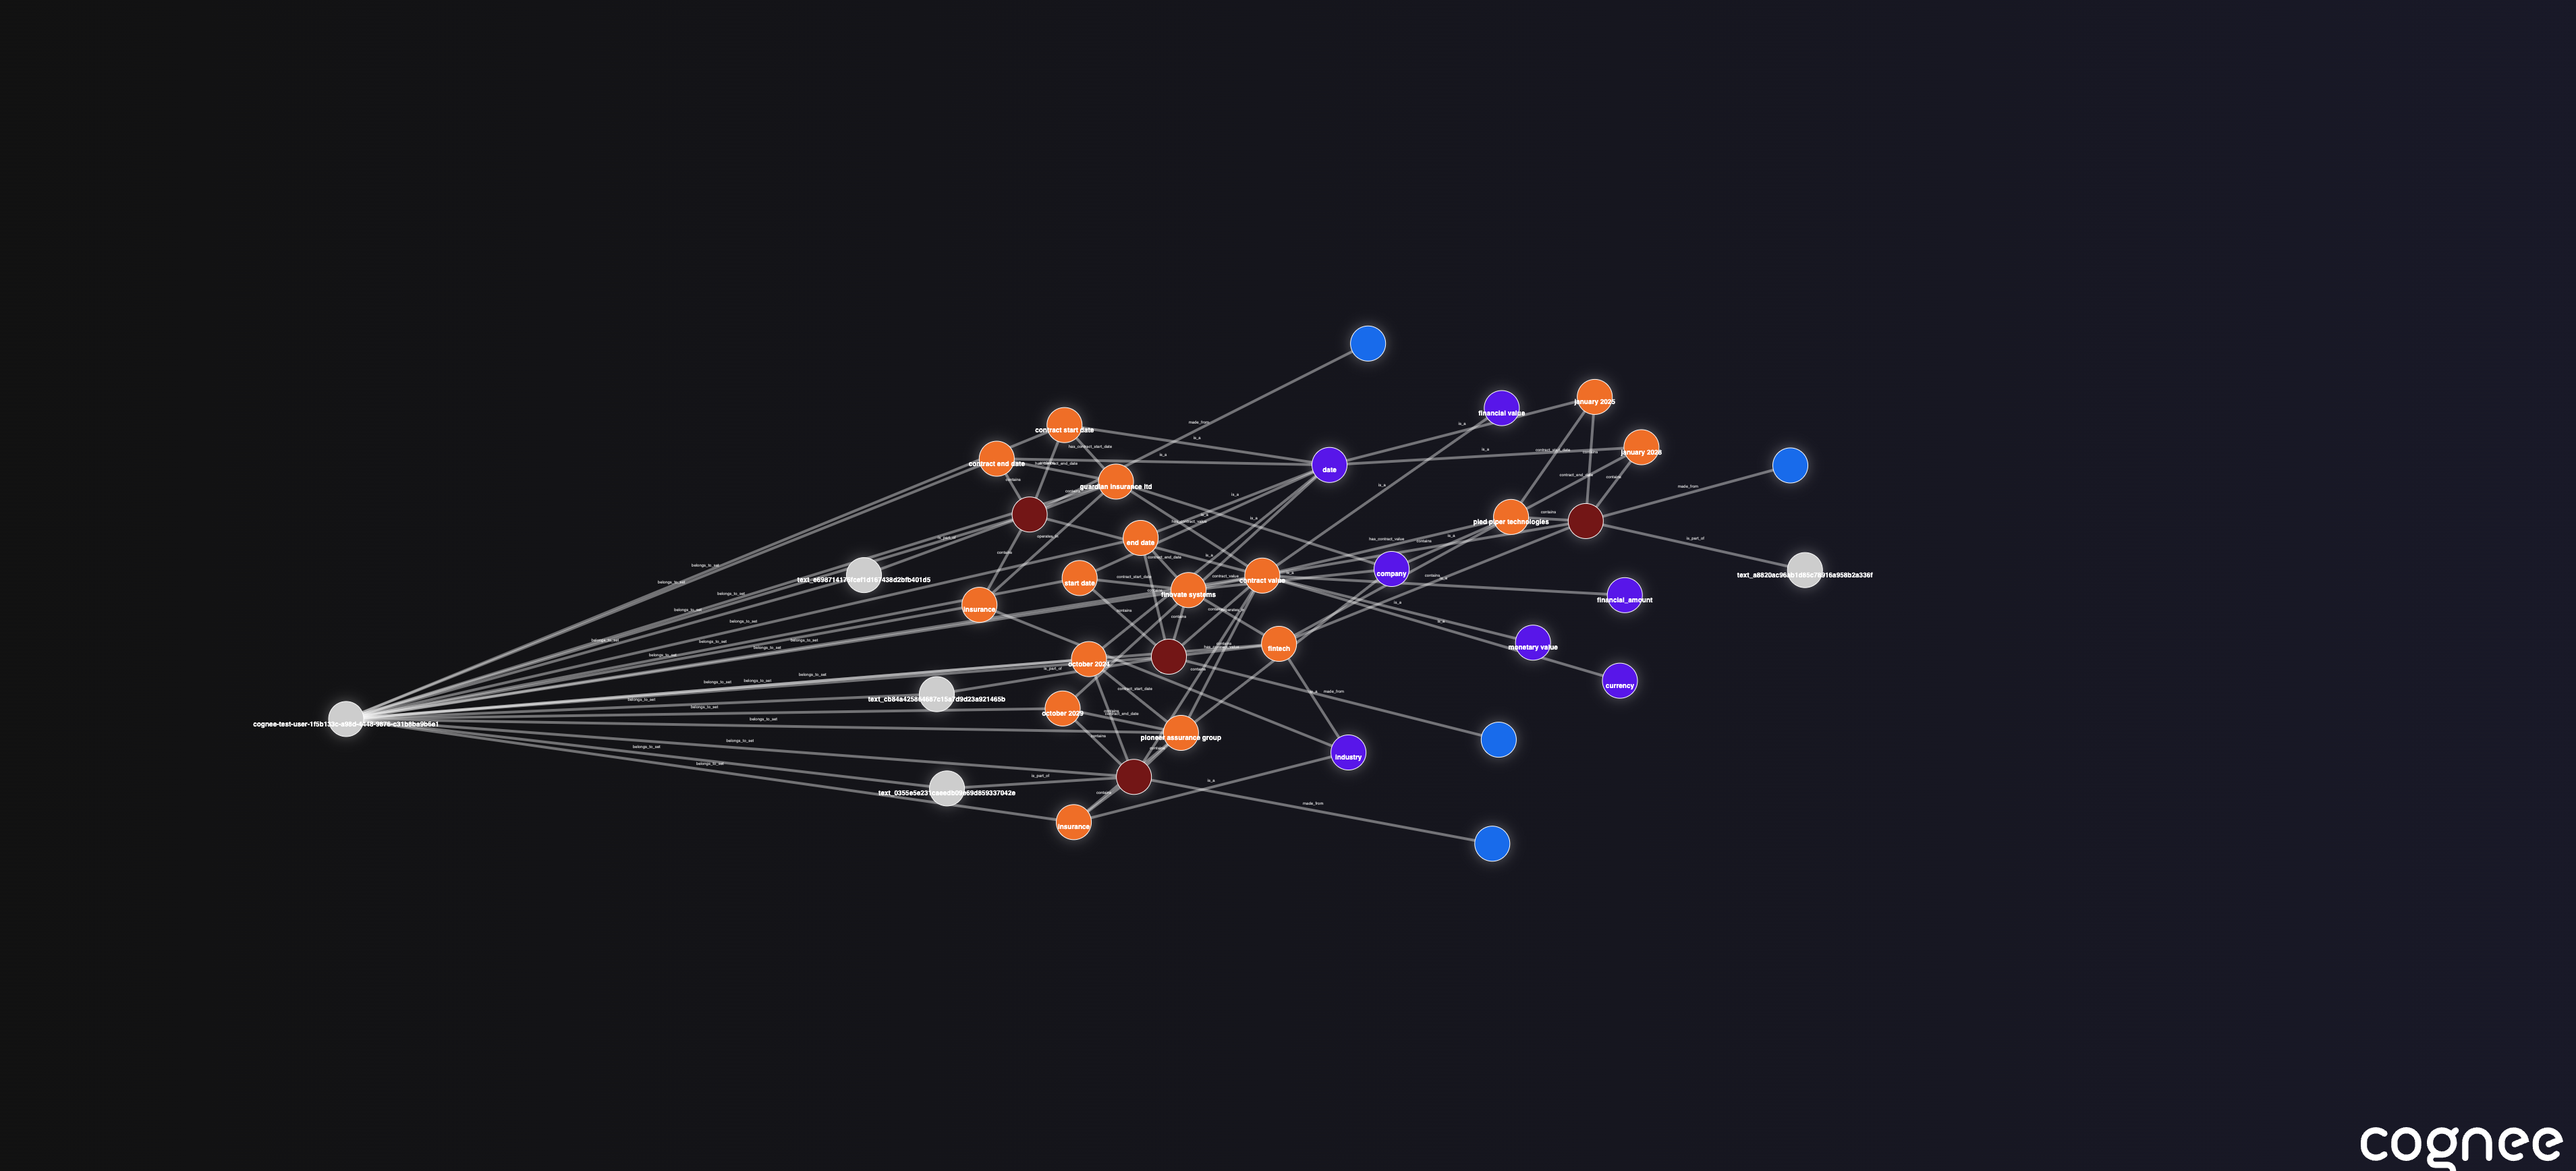

In [27]:
from IPython.display import Image, display

display(Image(filename="./images/sessionised_graph_screenshot.png"))

### Session Clustering Analysis

In this visualization, you can clearly observe **session-based data clustering**:

1. **Session Cluster**: All data processed within our specific session is grouped together around the session identifier
2. **Global Data**: Information added outside the session forms a separate cluster  
3. **Clean Separation**: The two data groups remain distinct while still being part of the same knowledge graph

This demonstrates how Cognee maintains both **session isolation** and **global knowledge accessibility**.


## Understanding Session ID Generation

Let's explore how session management works under the hood. You might ask:
- **Where does the session_id come from?**  
- **How can I control session_id generation?**


### session_id Source

Let's peek into `get_sessionized_cognee_tools()`:

```python
def get_sessionized_cognee_tools(session_id: Optional[str] = None) -> list:
    """
    Returns a list of cognee tools sessionized for a specific user.
    
    Args:
        session_id (str): The session ID to bind to all tools
        
    Returns:
        list: List of sessionized cognee tools
    """
    if session_id is None:
        import uuid
        uid = str(uuid.uuid4())
        session_id = f"cognee-test-user-{uid}"

    session_decorator = sessionised_tool(session_id)
    ...
```

Sessionization by definition requires a unique session_id to identify distinct sessions.

To preserve the UX of using LangGraph tools, we return tools just as any other integration, but before that we create the session_id and use closures to make tools aware of the state.

### Control How session_id Is Generated

In the parameter of `get_sessionized_cognee_tools()` you might notice an optional param for session_id.

Let's see how that works.

In [28]:
async def some_api_method() -> str:
    # authentication/other custom logic
    return "doofenshmirtz-inc-perry-the-platipus"


my_employee_id = await some_api_method()

add_tool, search_tool = get_sessionized_cognee_tools(my_employee_id)

super_fresh_agent = create_react_agent(
    "openai:gpt-4o-mini",
    tools=[
        add_tool,
        search_tool,
    ],
)

super_fresh_agent.step_timeout = None

response = super_fresh_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Doofenshmirtz Inc.". 
                Company is in the sci-fi invention industry. 
                Start date is Feb 2023 and end date is Feb 2026. 
                Contract value is £1.8M.
                """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Acme Rocket Skates Ltd". 
                Company is in the cartoon physics industry. 
                Start date is Oct 2024 and end date is Oct 2029. 
                Contract value is £4.2M.
                """
            ),
        ]
    }
)

print(response["messages"][-1].content)


Initialized session with session_id = doofenshmirtz-inc-perry-the-platipus

Using tool add_tool with user_id: doofenshmirtz-inc-perry-the-platipus

Using tool add_tool with user_id: doofenshmirtz-inc-perry-the-platipus

Adding data to cognee: Signed a contract with Doofenshmirtz Inc., a company in the sci-fi invention industry. Start date: Feb 2023, End date: Feb 2026, Contract value: £1.8M.

Adding data to cognee: Signed a contract with Acme Rocket Skates Ltd, a company in the cartoon physics industry. Start date: Oct 2024, End date: Oct 2029, Contract value: £4.2M.

Async operation completed successfully

2025-10-15T15:04:34.571809 [info     ] Pipeline run started: `4c7fb208-e513-5fc5-acda-33e393e48e97` [run_tasks_with_telemetry()]

2025-10-15T15:04:34.770450 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-10-15T15:04:34.974443 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]

2025-10-15T15:04:35.216397 [info     ] Coroutine ta

The contracts have been successfully recorded:

1. **Doofenshmirtz Inc.**
   - Industry: Sci-fi invention
   - Start Date: Feb 2023
   - End Date: Feb 2026
   - Contract Value: £1.8M

2. **Acme Rocket Skates Ltd**
   - Industry: Cartoon physics
   - Start Date: Oct 2024
   - End Date: Oct 2029
   - Contract Value: £4.2M


### Final Visualization

Let's visualize our final knowledge graph to see how all the different data sources and sessions are organized:


In [29]:
await visualize_graph(file_name="final_graph_visualization_custom_sessionized.html")


2025-10-15T15:05:16.921763 [info     ] Graph visualization saved as /Users/handekafkas/Documents/local-code/cognee-integration-langgraph/examples/final_graph_visualization_custom_sessionized.html [cognee.shared.logging_utils]

2025-10-15T15:05:16.922695 [info     ] The HTML file has been stored at path: /Users/handekafkas/Documents/local-code/cognee-integration-langgraph/examples/final_graph_visualization_custom_sessionized.html [cognee.shared.logging_utils]


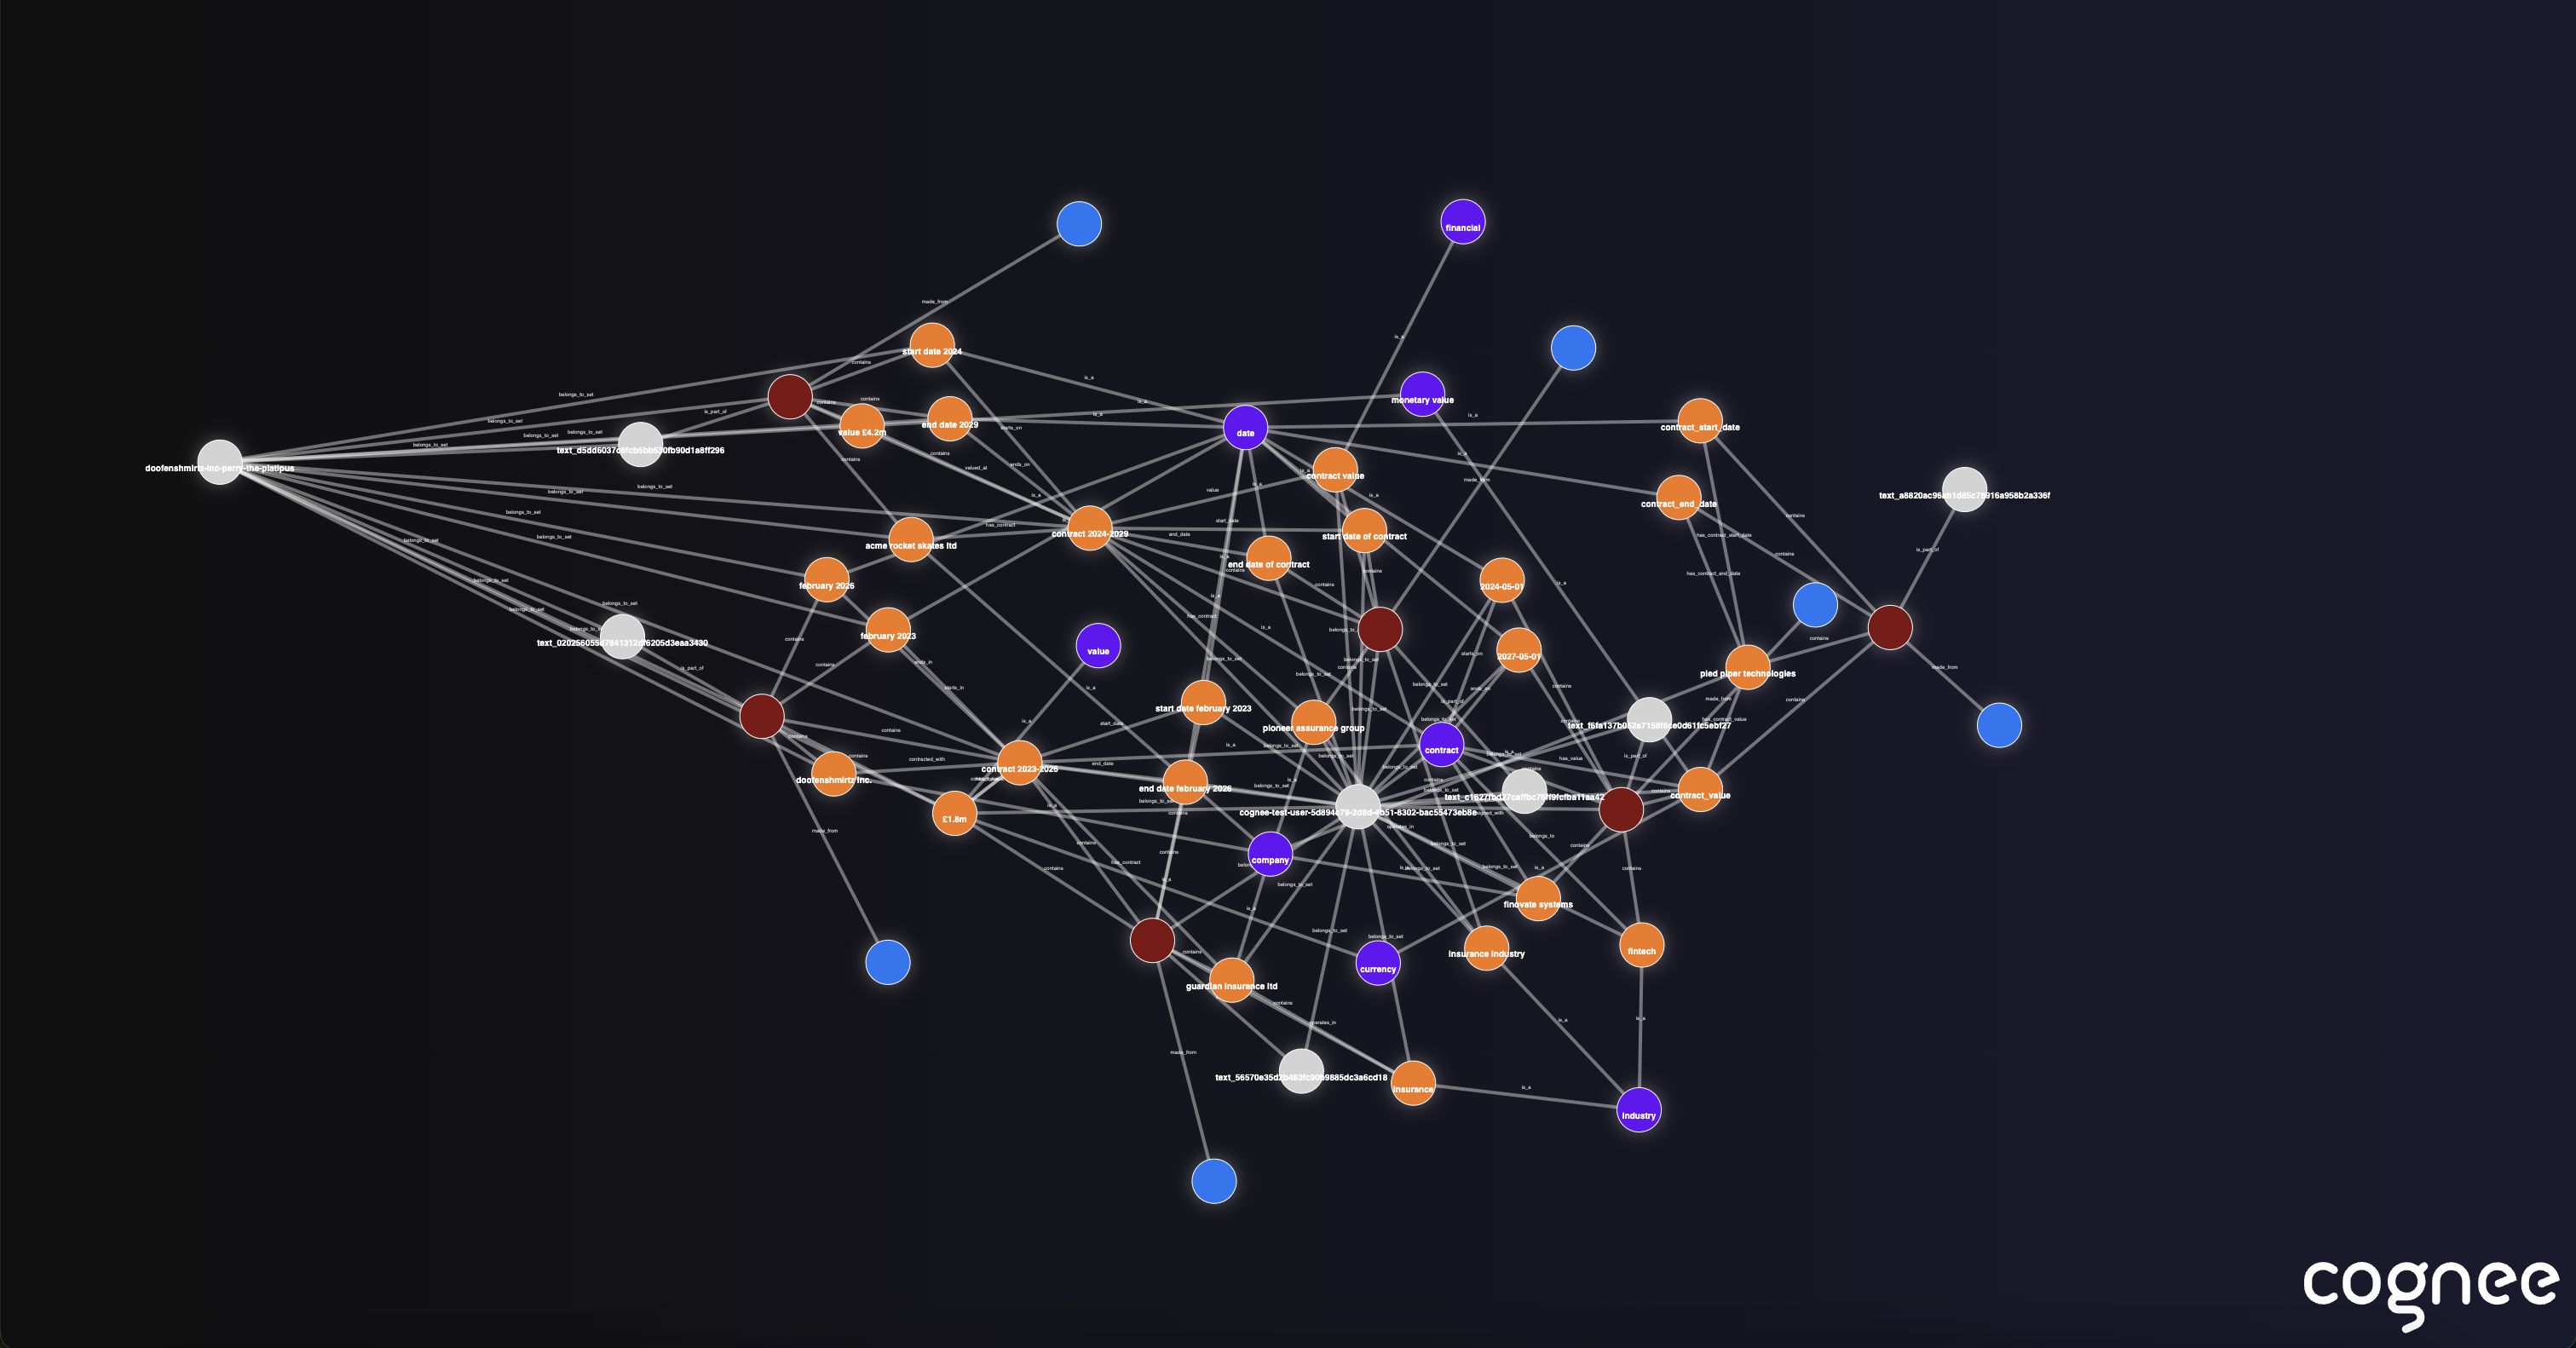

In [30]:
display(Image(filename="./images/custom_sessionized_graph_screenshot.png"))